# Infrared image colorization based on an unbalanced DCGAN
적외선 이미지를 색상화, 고해상도의 이미지로 만들어주는 모델
Backbone은 U-Net을 사용했으며, Decoder 부분에 Up-Sampling layer가 추가
* Input image shape = 480,640,1
* Output image shape = 1820,2560,3

## 1. Environment
* Python 3.6
* Tensorflow 1.7

## 2. Model Architecture
### 2.1 GAN
![GAN](./readme/model.PNG)

### 2.2 Generator
![GENERATOR](./readme/model_generator.PNG)

### 2.3 Discriminator
![DISCRIMINATOR](./readme/model_discriminator.png)

## 3. Test Pre-Trained ColorSRGAN Model
### 3.1 Requirements modules
ColorSRGAN Model을 inference 하기 위해 필요한 모듈 호출

In [9]:
import argparse
import os
import time

import cv2
import numpy as np
from skimage import color
from matplotlib import pyplot as plt

from src.utils import *
from src.model import create_model_gen

### 3.2 Building ColorSRGAN Model
모델을 호출하고 input/output 이미지의 shape를 지정
* Input Image Width=640, Height=480, Channel=1
* Output Image Width=2560, Height=1820, Channel=3

In [10]:
class Inference:

    def __init__(self, weight_path, init_size=(480, 640, 1)):

        self.init_size = init_size

        self.model_gen = create_model_gen(
            input_shape=self.init_size,
            output_channels=3)

        if os.path.exists(weight_path):
            self.model_gen.load_weights(weight_path)

    def process(self, img):

		# input image reshape
        input_tensor = image_reshape(img, self.init_size)

		# predict image
        output_tensor = self.model_gen.predict(input_tensor)[0]

		# change LAB to RGB color space & stretching (0, 1) to (0, 255)
        result = np.clip(np.abs(color.lab2rgb(output_tensor)), 0, 1) * 255

        return result


### 3.3 Load Weight & Read Image name
ColorSRGAN model에 필요한 Weights를 로드하고, 테스트 이미지의 이름을 read

In [11]:
# init parameter
weight_path = './src/weights/gen.hdf5'
path = './src/sample_images/'
save_path = './src/sample_images/result/'

create_dir(save_path)

# create network
net = Inference(weight_path=weight_path)

# read image file names
file_names = get_image_file_name(path)

file_names

['sample_image.png']

### 3.4 Predict image
테스트 이미지들을 읽고 network 통과 후, 이미지 저장

In [12]:
for file_name in file_names:

    # read image
    img = cv2.imread(path + file_name, cv2.IMREAD_GRAYSCALE)
    img = img.astype('float')

    # inference
    tic = time.time()
    output = net.process(img)
    toc = time.time()
    print(file_name, 'inference time(sec) =', toc - tic)

    # image write
    image_write(os.path.join(save_path, file_name), output)

sample_image.png inference time(sec) = 5.915917873382568


### 3.5 Result
show input/output image

(227, 340)

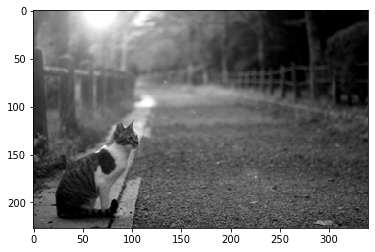

In [35]:
plt.imshow(img, cmap='gray', aspect='auto')
img.shape

(1920, 2560, 3)

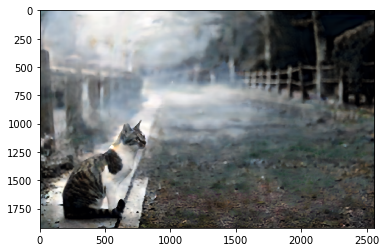

In [36]:
plt.imshow(output/255, aspect='auto')
output.shape

## 4. Performance
* 64x64 to 256x256 size image
* (A) : bilinear interpolation + Colorization
* (B) : bicubic interpolation + Colorization
* (C) : FSRCNN super-resolution + Colorization
* (D) : Unbalanced DCGAN

### 4.1 Inference GPU
* NVIDIA GTX1080 11GB

Time(msec)|(A)|(B)|(C)|(D)
:---:|:---:|:---:|:---:|:---:
Inference|5.035|7.127|4.110|5.260

### 4.2 Inference CPU
* Intel core i7-7500U(TODO)

Time(msec)|(A)|(B)|(C)|(D)
:---:|:---:|:---:|:---:|:---:
Inference|TODO|TODO|TODO|150.059

## 5. Results
64x64x1 infrared image to 256x256x3 RGB image

### 5.1 NIR (Near infrared) images
![NIR](./readme/result_nir.PNG)

### 5.2 FIR (Far infrared) images
![FIR](./readme/result_fir.PNG)